# NeuFit Modeling Pipeline

### Notes

#### Assumptions

- This Jupyter notebook runs best in Kernel: **neufit**

#### Neufit Modifyed Args Input/Output Details 

- Made changes in variables from args to names below so could be run / modifyed in Jupyer 
- If not trying to do custom plotting with colored - will be easier to use command line for this
- This also assumes that whatever dataset you chose already has the csv files created so had been run through *NeufitPipeline.ipynb*

- Old args input form neufit.py file - Example with combined dataset
```python 
args.data_file.name =/.../NeutralModels/Input_csv/combined_data.csv
args.data_file <open file '/.../NeutralModels/Input_csv/combined_data.csv', mode 'r' at 0x120b28c00>
args.ignore_level 0
args.rarefaction_level 0
args.taxonomy_file <open file '/.../NeutralModels/Input_csv/combined_taxonomy.csv', mode 'r' at 0x120b28c90>
```


- Modifyed varible names - Example with combined dataset
```python 
data_file_name = '/.../NeutralModels/Input_csv/combined_data.csv'
data_file = open(data_file_name, "r")
arg_ignore_level = 0
arg_rarefaction_level = 0
tax_file_name = '/.../NeutralModels/Input_csv/combined_taxonomy.csv'
tax_file = open(tax_file_name, "r")
```

## Pipeline Dependencies + Functions

### Dependencies

##### Import Packages

In [84]:
#Imports needed for Caitlin Functions
import pandas as pd
import qiime2 as q2
from biom import load_table #https://biom-format.org/documentation/generated/biom.load_table.html
from datetime import datetime
import os

#Imports needed for Neufit
import numpy as np
from lmfit import Parameters, Model, fit_report #conda-forge/lmfit
from scipy.stats import beta #[already installed]
from statsmodels.stats.proportion import proportion_confint #[already installed]
from os.path import splitext #[already installed]
from matplotlib import pyplot #[already installed]
from math import log10 #[already installed]
import scipy

##### File Locations

In [2]:
#Datasets: keynameDatatypeCollob
hutchKrakenAlex_biom = '/home/cguccion/rawData/01_11_2021_Hutch340_BE_Samples_LudmilAlexandrov/biom' #location of biom files from kraken->biom pipeline
TCGA_HNEC_EAC_WGS_Greg = '/home/cguccion/rawData/April2021_Greg_TCGA_WGS'

#Intermediate Files
neufit_input_path = '/home/cguccion/NeutralEvolutionModeling/data_tax_csv' #location of _data.csv and _tax.csv files for Neufit input

#Output Files
neufit_output_path = '/home/cguccion/NeutralEvolutionModeling/neufit_output' #location of all graphs and command line outputs from running Neufit


### Functions

#### Neufit Orginal Functions

##### PreSet Functions from Neufit

In [3]:
# neufit: Fit a neutral community model to species abundances, e.g. from an OTU table
#
# For the theory behind this see Sloan et al, Environ Microbiol 2006 8:732-740.
# To run on the example simulation data: python neufit.py sim_data.csv
# To link with the mock taxonomy use the -t sim_taxonomy.csv option
#
# Copyright (C) 2018 Michael Sieber (sieber.ecoevo.de)
# All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#
# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer.
# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
# ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
# WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR
# ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
# (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
# LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND
# ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
# SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
#
# Github: https://github.com/misieber/neufit

def beta_cdf(p, N, m):
    # Expected long term distribution under the neutral model (truncated cumulative beta-distribution)
    return beta.cdf(1.0, N*m*p, N*m*(1.0-p)) - beta.cdf(1.0/N, N*m*p, N*m*(1.0-p))
def subsample(counts, depth):
    # Subsamples counts to uniform depth, dropping all samples without enough depth
    for sample in counts:
        if counts[sample].sum() >= depth:
            flattened = np.repeat(np.arange(counts[sample].size), counts[sample])
            subsample = np.random.choice(flattened, depth, replace=False)
            counts[sample] = np.bincount(subsample, minlength=counts[sample].size)
        else:
            #CG: changed the following print statment from Python2 to Python3 
            print('dropping sample ' + sample + ' with ' + str(counts[sample].sum()) + ' reads < ' + str(depth))
            counts = counts.drop(sample, axis=1)
    return counts

def non_negative_int(arg):
    # Argparser type: non-negative int
    nnint = int(arg)
    if nnint < 0:
        raise ArgumentTypeError(arg + ' < 0, must be non-negative')
    return nnint

##### Main Neufit Section

In [102]:
'''
All the code in the function below was written by the orginal Neufit authors, not me and is from the neufit.py file.
neufit.py: https://github.com/misieber/neufit/blob/master/neufit.py

Here are the following changes I made:
- Turned it into a function instead of using argv as input
    -There are specific notes on what I changed in the 'Notes: Neufit Modifyed Args Input/Output Details' section.
-Changed was all syntax from Python2 to Python3.
-Changed all print statments to write to file statements
    - Made any necissary edits to allow data to be printed to file instead of terminal 
'''
def main_neufit(output_filename, dataset_type, _data_filename, _taxonomy_filename, full_non_neutral = False, arg_ignore_level = 0, arg_rarefaction_level = 0):
    '''Inputs:  output_filename : the name which will be at the front of all the files; ex. 'combined'
                dataset_type : the dataset type we have from here: ('hutchKraken', 'gregTCGA')
                _data_filename = path of []_data.csv file needed for Neufit to run
                _taxonomy_filename = path of []_taxonomy.csv file needed for Neufit to run
                arg_ignore_level = 0 ; default set from orginal Neufit program
                arg_rarefaction_level = 0; default set from orginal Neufit program 
       Outputs: file_header = file path for neufit outpus: The path+dataGroup name + date stamp to be used for all parts of Neufit run: ex. /home/cguccion/NeutralEvolutionModeling/neufit_output/hutchKrakenAlex_combined_2021-08-26_13:24:22  
                occurr_freqs = pandas df that Neufit created in the orginal program but didn't specifcally output orginally
                    - Headers of csv: otu_id, mean_abundance, occurrence, Kingdom, Phylum, Class, Order, Family, Genus, Species, predicted_occurrence, lower_conf_int, upper_conf_int
                    - I used this occur_freqs df in order to figure out which species is the most non-neutral
                    - I believe this is what Neufit uses to physical plot the dots on the graph as well 
                n_reads = Number of reads (from orginal program)
                n_samples = Number of smaples (from orginal program)
                r_square = R^2 value (from orginal program)
                beta_fit = stats on the preformance of the model (from orginal program)
               *Runs the main section of neufit'''
    
    ##Added by Caitlin ~ Push output to file instead of printing to screen
    
    #Grab and format data/time
    time = datetime.time(datetime.now())
    date = datetime.date(datetime.now())
    h,s = str(time).split(".") #Split  the string into  hours/min and seconds
    
    #Create file_header which holds the path / location for all future Neufit outpus
    file_header = str(neufit_output_path) + "/" + str(dataset_type) + '/' + str(output_filename) + '/' + str(output_filename) + '_' + str(date) + "_" + str(h)
    
    #Creates directory for all Neufit Outputs if it doesn't already exist 
    dir_name = str(neufit_output_path) + "/" + str(dataset_type) + '/' + str(output_filename)
    os.makedirs(dir_name, exist_ok=True)
    
    #Create and open file for Neufit Output txt file
    fn= str(file_header) + ".txt"
    file = open(fn, 'w')
    
    #Print statments with important info
    print("Running dataset: " + str(dataset_type) + "Category:" + str(output_filename) + '\n')
    ##
    
    # Writes dataset info to Neufit output file + calculates and writes the number of samples/ reads in the file
    file.write('Corresponding csv file: ' + _data_filename + '\n')
    abundances = pd.read_table(_data_filename, header=0, index_col=0, sep='\t').astype(int)
    abundances = abundances[abundances.sum(1) > arg_ignore_level]
    file.write ('Dataset contains ' + str(abundances.shape[1]) + ' samples (sample_id, reads): \n')
    ##Caitlin
    #The following loop is used instead of 'print abundances.sum(0)' so that it can be written to a file
    for index, col in abundances.iteritems():
        col_sum = 0
        for i in col:
            col_sum += i
        file.write (index + '\t' + str(col_sum) + '\n')
    file.write ('\n')
    ##

    # Determine uniform read depth
    if arg_rarefaction_level == 0 or arg_rarefaction_level > max(abundances.sum(0)):
        arg_rarefaction_level = min(abundances.sum(0))
        file.write ('rarefying to highest possible uniform read depth'),
    else:
        file.write ('rarefying to custom rarefaction level'),
    file.write ('(' + str(arg_rarefaction_level) + ' reads per sample) \n')

    # Optionally subsample the abundance table, unless all samples already have the required uniform read depth
    if not all(n_reads == arg_rarefaction_level for n_reads in abundances.sum(0)):
        abundances = subsample(abundances, arg_rarefaction_level)
        abundances = abundances[abundances.sum(1) > 0]

    # Dataset shape
    n_otus, n_samples = abundances.shape
    n_reads = arg_rarefaction_level

    file.write ('fitting neutral expectation to dataset with ' + str(n_samples) + ' samples and ' + str(n_otus) + ' otus \n \n')
    # Calculate mean relative abundances and occurrence frequencies
    mean_relative_abundance = (1.0*abundances.sum(1))/n_reads/n_samples
    occurrence_frequency = (1.0*np.count_nonzero(abundances, axis=1))/n_samples

    occurr_freqs = pd.DataFrame(mean_relative_abundance, columns=['mean_abundance'])
    occurr_freqs.index.name = 'otu_id'
    occurr_freqs['occurrence'] = occurrence_frequency
    occurr_freqs = occurr_freqs.sort_values(by=['mean_abundance'])

    # Join with taxonomic information (optional)
    if _taxonomy_filename != None: #Changed <> to !=
        taxonomy = pd.read_table(_taxonomy_filename, header=0, index_col=0, sep='\t')
        taxonomy.index.name = 'otu_id'
        occurr_freqs = occurr_freqs.join(taxonomy)
    # Fit the neutral model
    params = Parameters()
    params.add('N', value=n_reads, vary=False)
    params.add('m', value=0.5, min=0.0, max=1.0)
    beta_model = Model(beta_cdf)
    beta_fit = beta_model.fit(occurr_freqs['occurrence'], params, p=occurr_freqs['mean_abundance'])

    # Report fit statistics
    r_square = 1.0 - np.sum(np.square(occurr_freqs['occurrence'] - beta_fit.best_fit))/np.sum(np.square(occurr_freqs['occurrence'] - np.mean(occurr_freqs['occurrence'])))
    file.write (fit_report(beta_fit))
    file.write ('\n R^2 = ' + '{:1.2f}'.format(r_square))
    print(fit_report(beta_fit))
    print('\n R^2 = ' + '{:1.2f}'.format(r_square))
    print('=========================================================')

    # Adding the neutral prediction to results
    occurr_freqs['predicted_occurrence'] = beta_fit.best_fit
    occurr_freqs['lower_conf_int'], occurr_freqs['upper_conf_int'] = proportion_confint(occurr_freqs['predicted_occurrence']*n_samples, n_samples, alpha=0.05, method='wilson')

    # Save non-neutral otus (here simply determined by lying outside the confidence intervals)
    above = occurr_freqs[occurr_freqs['occurrence'] > occurr_freqs['upper_conf_int']]
    below = occurr_freqs[occurr_freqs['occurrence'] < occurr_freqs['lower_conf_int']]
    
    #Create orginal non neutral output file from Neufit
    if full_non_neutral == True:
        pd.concat((above, below)).to_csv(str(file_header) + '_FullNonNeutral.csv')
    
    file.close()
    
    return(occurr_freqs, n_reads, n_samples, r_square, beta_fit, file_header)

##### Neufit Plotting

In [32]:
'''
All the code in the function below was written by the orginal Neufit authors, not me and is from the neufit.py file.
neufit.py: https://github.com/misieber/neufit/blob/master/neufit.py

Here are the following changes I made:
- Turned it into a function 
- Added a plot clearing option to avoid double keys
'''
def neufit_plot(occurr_freqs, n_reads, n_samples, r_square, beta_fit, file_header):
    '''Inputs: occurr_freqs = pandas df that Neufit created in the orginal program but didn't specifcally output orginally
                    - Headers of csv: otu_id, mean_abundance, occurrence, Kingdom, Phylum, Class, Order, Family, Genus, Species, predicted_occurrence, lower_conf_int, upper_conf_int
                    - I used this occur_freqs df in order to figure out which species is the most non-neutral
                    - I believe this is what Neufit uses to physical plot the dots on the graph as well 
               n_reads = Number of reads (from orginal program)
               n_samples = Number of smaples (from orginal program)
               r_square = R^2 value (from orginal program)
               beta_fit = stats on the preformance of the model (from orginal program)
               file_header = file path for all neufit outpus: The path+dataGroup name + date stamp to be used for all parts of Neufit run: ex. /home/cguccion/NeutralEvolutionModeling/neufit_output/hutchKrakenAlex_combined_2021-08-26_13:24:22  
        Outputs: ! The orginal plot that Neufit outputs (just black dots) - will print to the screen but not save when run
                 fn = default filename for neufit plot : customName_NeutralFitPlot.png -- Will often not need this 
                 *Creates the plot for Neufit '''
    
    
    pyplot.cla() #Clears previous plot - to avoid double keys

    # Prepare results plot
    pyplot.xlabel('Mean relative abundance across samples', fontsize=15)
    pyplot.xscale('log')
    x_range = np.logspace(log10(min(occurr_freqs['mean_abundance'])/10), 0, 1000)
    pyplot.xlim(min(x_range), max(x_range))
    pyplot.xticks(fontsize=16)
    pyplot.ylabel('Occurrence frequency in samples', fontsize=15)
    pyplot.ylim(-0.05, 1.05)
    pyplot.yticks(fontsize=16)

    # Plot data points
    pyplot.plot(occurr_freqs['mean_abundance'], occurr_freqs['occurrence'], 'o', markersize=6, fillstyle='full', color='black')

    # Plot best fit
    pyplot.plot(x_range, beta_cdf(x_range, n_reads, beta_fit.best_values['m']), '-', lw=5, color='darkred')
    lower, upper = proportion_confint(beta_cdf(x_range, n_reads, beta_fit.best_values['m'])*n_samples, n_samples, alpha=0.05, method='wilson')
    pyplot.plot(x_range, lower, '--', lw=2, color='darkred')
    pyplot.plot(x_range, upper, '--', lw=2, color='darkred')
    pyplot.fill_between(x_range, lower, upper, color='lightgrey')

    pyplot.text(0.05, 0.9, '$R^2 = ' + '{:1.2f}'.format(r_square) + '$', fontsize=16, transform=pyplot.gca().transAxes)
    pyplot.tight_layout()
    
    fn = file_header + '_NeutralFitPlot.png'
    return(fn)

#### Caitlin Written Functions

##### biome2data_tax

In [112]:
# Caitlin Guccione, 08-25-2021

def biom2data_tax(datasetName, biomFilename, finalFilename):
    '''Inputs: datasetName = filename of dataset ex. hutchKrakenAlex_biom -- found in set paths above
               biomFilename = filename of biom file found in datasetName path above
               finalFilename = filename to be used in _data.csv file for neuFit
       Outputs: fnD = File location of [name]_data.csv
                ![name]_data.csv = Creates a data.csv file to be input into Neufit located at 'neufit_input'
                fnT = File location of [name]_taxonomy.csv
                ![name]_taxonomy.csv = Creates a taxonomy.csv file to be input into Neufit located at 'neufit_input'
       * Imports biom file -> pandas dataframe -> data.csv, taxonomy.csv as desired by neufit'''
    
    #Make filename and import data
    fullFilename = datasetName + '/' + biomFilename
    featureTable = load_table(fullFilename) #https://biom-format.org/documentation/generated/biom.load_table.html
    
    #Create _data.csv
    pandas_featureTable = pd.DataFrame(featureTable.matrix_data.toarray(), featureTable.ids('observation'), featureTable.ids())
    fnD = neufit_input_path + '/' + finalFilename + '_data.csv'
    pandas_featureTable.to_csv(fnD, sep='\t')
    
    #Create _taxonomy.csv
    pandas_TaxTable = pd.DataFrame(featureTable.metadata_to_dataframe('observation'))
    pandas_TaxTable.set_axis(['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'], axis=1)
    fnT = neufit_input_path + '/' + finalFilename + '_taxonomy.csv'
    pandas_TaxTable.to_csv(fnT, sep='\t')
    
    '''
    #Create Neufit string to run progam in terminal
    #Can now run Neufit entirely from this notebook so don't need this command
    py = 'python2 /Users/cguccione/Documents/Classes/Kit_Lab/Tools/neufit/neufit.py '
    fnD = finalFilename + '_data.csv'
    fnT = finalFilename + '_taxonomy.csv'
    neufit_command = py + fnD + ' -t ' + fnT
    
    return(neufit_command)
    Outputs: ![name]_data.csv = Creates a data.csv file to be input into Neufit located at 'neufit_input'
                ![name]_taxonomy.csv = Creates a taxonomy.csv file to be input into Neufit located at 'neufit_input'
    '''
    
    return(fnD, fnT)


##### non_neutral_outliers

In [38]:
def non_neutral_outliers(file_header, occurr_freqs, non_save, threshold = 0.5):
    '''Inputs: file_header = file path for neufit outpus: The path+dataGroup name + date stamp to be used for all parts of Neufit run: ex. /home/cguccion/NeutralEvolutionModeling/neufit_output/hutchKrakenAlex_combined_2021-08-26_13:24:22  
               occurr_freqs = pandas df that Neufit created in the orginal program but didn't specifcally output orginally
                    - Headers of csv: otu_id, mean_abundance, occurrence, Kingdom, Phylum, Class, Order, Family, Genus, Species, predicted_occurrence, lower_conf_int, upper_conf_int
                    - I used this occur_freqs df in order to figure out which species is the most non-neutral
                    - I believe this is what Neufit uses to physical plot the dots on the graph as well
               threshold = 0.5; autoset to 0.5, but determines what bacteria are considered non-neutral
        Outputs: ! [name]_NonNeutralOutliers.csv
                *Creates the most Non-neutral csv file '''
    
    #Create dataframe
    standoutMicrobes = pd.DataFrame(columns = ('Difference off Neutral Model', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'))
    
    #Loop and find most non-neutral microbes based upon threshold
    row_count = 0
    for i,j in occurr_freqs.iterrows():
        diff = abs(j['occurrence'] - j['predicted_occurrence'])
        if diff > threshold:
            standoutMicrobes.loc[row_count] = [diff, j['Kingdom'], j['Phylum'], j['Class'], j['Order'], j['Family'], j['Genus'], j['Species']]
            row_count +=1
    standoutMicrobes = standoutMicrobes.sort_values(by =['Difference off Neutral Model'], ascending=False)
    
    #Display and export non-neutral microbes as csv
    print("\nTop NonNeutral Microbes")
    display(standoutMicrobes)
    print('=========================================================\n')
    
    fn = file_header + '_NonNeutral_Outliers.csv'
    
    if non_save == False:
        standoutMicrobes.to_csv(fn, sep = '\t')

##### custom_color_plot

If you want to add another custom color:
1. Create a new section with bacteria and Mean Abundance and Occurance lists
2. Add to the for loop at bottom of section as well
3. Add custum bacteria to plot

In [31]:
def custom_color_plot(occurr_freqs, n_reads, n_samples, r_square, beta_fit, file_header):
    '''Inputs: file_header = file path for neufit outpus: The path+dataGroup name + date stamp to be used for all parts of Neufit run: ex. /home/cguccion/NeutralEvolutionModeling/neufit_output/hutchKrakenAlex_combined_2021-08-26_13:24:22  
               occurr_freqs = pandas df that Neufit created in the orginal program but didn't specifcally output orginally
                    - Headers of csv: otu_id, mean_abundance, occurrence, Kingdom, Phylum, Class, Order, Family, Genus, Species, predicted_occurrence, lower_conf_int, upper_conf_int
                    - I used this occur_freqs df in order to figure out which species is the most non-neutral
                    - I believe this is what Neufit uses to physical plot the dots on the graph as well
               n_reads = Number of reads (from orginal program)
               n_samples = Number of smaples (from orginal program)
               r_square = R^2 value (from orginal program)
               beta_fit = stats on the preformance of the model (from orginal program)
        Outputs: ! The plot that Neufit outputs + the colored dots - will print to the screen but not save when run
                 fn = default filename for neufit plot : _NeutralFitPlot_withNonNeutralColors.png
                 *Creates the plot for Neufit + with colored dots '''
    
    #Create orginal black plot
    neufit_plot(occurr_freqs, n_reads, n_samples, r_square, beta_fit, file_header)
    
    #If you want to add a new custom color, follow the steps below on what to add where (more info above as well)
    
    # --------- STEP 1 ---------
    # Create mean abundance and occurance list for bacteria 

    #Phylori
    MA_S_pylori = [] #Mean_Abundance, Species , phylori
    O_S_pylori = [] #Occurrance

    #Proteobacteria
    MA_P_Proteobacteria = []
    O_P_Proteobacteria = []

    #Streptococcus
    MA_G_Streptococcus = []
    O_G_Streptococcus = []

    #Bacteroidetes
    MA_P_Bacteroidetes = []
    O_P_Bacteroidetes = []

    # --------- STEP 2 ---------
    # Add to customized lists when hitting bacteria in neutral list 

    #for i, j in neutral.iterrows():
    for i,j in occurr_freqs.iterrows():
        if j['Species'] == 's__pylori':
            MA_S_pylori.append(j['mean_abundance'])
            O_S_pylori.append(j['occurrence'])
        if j['Phylum'] == 'p__Proteobacteria':
            MA_P_Proteobacteria.append(j['mean_abundance'])
            O_P_Proteobacteria.append(j['occurrence'])
        if j['Genus'] == 'g__Streptococcus':
            MA_G_Streptococcus.append(j['mean_abundance'])
            O_G_Streptococcus.append(j['occurrence'])
        if j['Phylum'] == 'p__Bacteroidetes':
            MA_P_Bacteroidetes.append(j['mean_abundance'])
            O_P_Bacteroidetes.append(j['occurrence'])

    # --------- STEP 3 ---------
    # Override coloring of dots in current plot with new colors

    pyplot.plot(MA_P_Proteobacteria, O_P_Proteobacteria, 'o', markersize=6, fillstyle='full', color='green', label="Proteobacteria")
    pyplot.plot(MA_G_Streptococcus, O_G_Streptococcus, 'o', markersize=6, fillstyle='full', color='orange', label="Streptococcus")
    pyplot.plot(MA_P_Bacteroidetes, O_P_Bacteroidetes, 'o', markersize=6, fillstyle='full', color='purple', label="Bacteroidetes")
    pyplot.plot(MA_S_pylori, O_S_pylori, 'o', markersize=6, fillstyle='full', color='blue', label='H.pylori')

        
    plot_fn = file_header + '_NeutralFitPlot_withNonNeutralColors.png'
    
    return(plot_fn)

##### save_plot

In [10]:
def save_plot(fn):
    ##Just saves the plot given a filename
    pyplot.legend(loc="center left")
    pyplot.savefig(fn)

##### Neufit_Pipeline_Main

In [115]:
def Neufit_Pipeline_Main(output_filename, dataset_type, custom_filename, norm_graph, colored_graph, non_neutral, non_save = False, full_non_neutral = False):
    '''
    Inputs:    output_filename : the name which will be at the front of all the files; ex. 'combined'
               dataset_type : the dataset type we have from here: ('hutchKraken', 'gregTCGA')
               custom_filename : depedant on the dataset:
                       - hutchKraken : the name of the biom file ex.'combined_biome'
               
               norm_graph : True/False : Prints and saves the neutral evolution graph without any coloring
               colored_graph : True/False : Prints and saves the neutral evolution graph without any coloring
               non_neutral : True/False : Prints and saves the most non-neutral microbes in csv file               
               
               Default inputs to be changed mainly for testing purposes:
               non_save : True/False, False = default, the following will not be SAVED just printed to the screen
                           - * This is intened for testing only! *
                           - norm_graph, colored_graph, non_neutral_csv 
                           - **Took away this feature ** [It will still create [name]_data.csv and [name]_taxonomy.csv but will delete them after running]
               full_non_neutral: True/False : Creates a csv file from orginal Neufit program with information about what is neutral and how far off the curve each point is
                   - csv will have: otu_id, mean_abundance, occurrence, Kingdom, Phylum, Class, Order, Family, Genus, Species, predicted_occurrence, lower_conf_int, upper_conf_int

              *The main function for the pipeline which calls all other functions*
    
    '''
    
    #Convert data from biom to csv files for Neufit
    if dataset_type == 'hutchKraken':
        fnData, fnTaxonomy = biom2data_tax(hutchKrakenAlex_biom, custom_filename, output_filename)
    elif dataset_type == 'gregTCGA':
        print()
        
    #Run Neufit
    occurr_freqs, n_reads, n_samples, r_square, beta_fit, file_header = main_neufit(output_filename, dataset_type, fnData, fnTaxonomy, full_non_neutral)
    
    #Neufit Plotting and Non-neutral Outline
    if norm_graph == True: #Neutral evolution graph, no color
        nc_fn = neufit_plot(occurr_freqs, n_reads, n_samples, r_square, beta_fit, file_header)
        if non_save == False:
            save_plot(nc_fn)
    if colored_graph == True:#Neutral evolution graph with colors
        cc_fn = custom_color_plot(occurr_freqs, n_reads, n_samples, r_square, beta_fit, file_header)
        if non_save == False:
            save_plot(cc_fn)
    if non_neutral == True:
        non_neutral_outliers(file_header, occurr_freqs, non_save)
        
    #Easier to delete the Neufit text file then to not create it
    if non_save == True:
        neufit_fn= str(file_header) + ".txt"
        os.remove(neufit_fn)
    
    #Optional cleanup step with non_save to remove taxonomy and data files - these just overwrite themseleves so not usally a big issue
    '''
    if non_save == True: #Delete [name]_data.csv and [name]_taxonomy.csv to reduce cluter
        os.remove(fnData)
        os.remove(fnTaxonomy)
    '''


## Choose Dataset + Run Pipeline

### Hutch Kraken Dataset: Ludmil Alexandrov

##### Dataset Info

**Background on Data**
- This data was orginally in the form of Kraken data that we recived from a rotation student in Ludmill Alexandrov's lab 
    - We didn't have access to the fastq files, only the Kraken data due to a limited number of keys
- This data is originally from Fread Hutch and consistets of progressor and non-progressor patients in reference to EAC

**Information on How to Run Data**
- This dataset comes with biome files with the taxonomic data already imported into the files
    - This allows us to simply run **biom2data_tax** which is all set in the Neufit_Pipeline_Main Function
- This pipeline assumes everything from Kraken (including this dataset) is already in the **biome** format    
    - In the future we will not be using Kraken but will have the full fastq files 
    - The pipeline used previously to create the kraken-biome files uses: 'pip install krakenplot' which 
        didnt' work on the cluster (1 hour attempt) so wasn't worth implementation
    - More details on how to convert files from Kraken to biom on the command line found on this github: https://github.com/cguccione/BEProgression2EAC/tree/main/PipelineTesting/KrakenBiome_Pipeline

#### Combined Data (Everything in the dataset)

/home/cguccion/.conda/envs/neufit/lib/python3.5/site-packages/ipykernel_launcher.py:24: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.


Running dataset: hutchKrakenCategory:combined

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 12
    # data points      = 5678
    # variables        = 1
    chi-square         = 15.1564315
    reduced chi-square = 0.00266980
    Akaike info crit   = -33645.4270
    Bayesian info crit = -33638.7826
[[Variables]]
    N:  2108 (fixed)
    m:  0.32033901 +/- 0.00831252 (2.59%) (init = 0.5)

 R^2 = 0.82

Top NonNeutral Microbes


,Difference off Neutral Model,Kingdom,Phylum,Class,Order,Family,Genus,Species
2,0.962040,k__Viruses,p__Peploviricota,c__Herviviricetes,o__Herpesvirales,f__Herpesviridae,g__Roseolovirus,s__Human betaherpesvirus 6A
1,0.935281,k__Viruses,p__Peploviricota,c__Herviviricetes,o__Herpesvirales,f__Herpesviridae,g__Roseolovirus,s__Human betaherpesvirus 6B
3,0.761747,k__Bacteria,p__Proteobacteria,c__Epsilonproteobacteria,o__Campylobacterales,f__Helicobacteraceae,g__Helicobacter,s__pylori
4,0.629403,k__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pasteurellales,f__Pasteurellaceae,g__Haemophilus,s__parahaemolyticus
0,0.580051,k__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Pseudomonadaceae,g__Pseudomonas,s__sp. J380


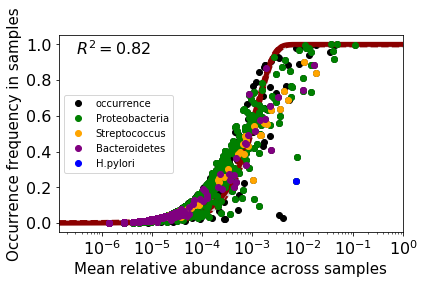

In [116]:
'''Choose True or False for the following parameters:
               norm_graph : True/False : Prints and saves the neutral evolution graph without any coloring
               colored_graph : True/False : Prints and saves the neutral evolution graph without any coloring
               non_neutral : True/False : Prints and saves the most non-neutral microbes in csv file
'''
norm_graph = True
colored_graph = True
non_neutral = True

#Run with no output files
#Neufit_Pipeline_Main('combined', 'hutchKraken', 'combined_biome', norm_graph, colored_graph, non_neutral, non_save = True)

#Run with all possible output files
Neufit_Pipeline_Main('combined', 'hutchKraken', 'combined_biome', norm_graph, colored_graph, non_neutral, full_non_neutral = True)

### Greg TCGA Multi - Location Data

In [ ]:
print(biom2data_tax(TCGA_HNEC_EAC_WGS_Greg, '116639_feature-table-TCGA-WGS-PT-ESCA-HNSC.biom', 'greg_d1'))

print(biom2data_tax(TCGA_HNEC_EAC_WGS_Greg, '116640_feature-table-TCGA-WGS-STN-ESCA-HNSC.biom', 'greg_d2'))

# Extra Notes

In [8]:
# Read data
print ('reading ' + data_file_name)
abundances = pd.read_table(data_file, header=0, index_col=0, sep='\t').astype(int)
abundances = abundances[abundances.sum(1) > arg_ignore_level]
print ('dataset contains ' + str(abundances.shape[1]) + ' samples (sample_id, reads):')
print (abundances.sum(0))

# Determine uniform read depth
if arg_rarefaction_level == 0 or arg_rarefaction_level > max(abundances.sum(0)):
    arg_rarefaction_level = min(abundances.sum(0))
    print ('rarefying to highest possible uniform read depth'),
else:
    print ('rarefying to custom rarefaction level'),
print ('(' + str(arg_rarefaction_level) + ' reads per sample)')

# Optionally subsample the abundance table, unless all samples already have the required uniform read depth
if not all(n_reads == arg_rarefaction_level for n_reads in abundances.sum(0)):
    abundances = subsample(abundances, arg_rarefaction_level)
    abundances = abundances[abundances.sum(1) > 0]

# Dataset shape
n_otus, n_samples = abundances.shape
n_reads = arg_rarefaction_level

print ('fitting neutral expectation to dataset with ' + str(n_samples) + ' samples and ' + str(n_otus) + ' otus')
# Calculate mean relative abundances and occurrence frequencies
mean_relative_abundance = (1.0*abundances.sum(1))/n_reads/n_samples
occurrence_frequency = (1.0*np.count_nonzero(abundances, axis=1))/n_samples

occurr_freqs = pd.DataFrame(mean_relative_abundance, columns=['mean_abundance'])
occurr_freqs.index.name = 'otu_id'
occurr_freqs['occurrence'] = occurrence_frequency
occurr_freqs = occurr_freqs.sort_values(by=['mean_abundance'])

# Join with taxonomic information (optional)
if tax_file != None: #Changed <> to !=
    taxonomy = pd.read_table(tax_file, header=0, index_col=0, sep='\t')
    taxonomy.index.name = 'otu_id'
    occurr_freqs = occurr_freqs.join(taxonomy)
# Fit the neutral model
params = Parameters()
params.add('N', value=n_reads, vary=False)
params.add('m', value=0.5, min=0.0, max=1.0)
beta_model = Model(beta_cdf)
beta_fit = beta_model.fit(occurr_freqs['occurrence'], params, p=occurr_freqs['mean_abundance'])

# Report fit statistics
r_square = 1.0 - np.sum(np.square(occurr_freqs['occurrence'] - beta_fit.best_fit))/np.sum(np.square(occurr_freqs['occurrence'] - np.mean(occurr_freqs['occurrence'])))
print(fit_report(beta_fit))
print ('R^2 = ' + '{:1.2f}'.format(r_square))

# Adding the neutral prediction to results
occurr_freqs['predicted_occurrence'] = beta_fit.best_fit
occurr_freqs['lower_conf_int'], occurr_freqs['upper_conf_int'] = proportion_confint(occurr_freqs['predicted_occurrence']*n_samples, n_samples, alpha=0.05, method='wilson')

# Save non-neutral otus (here simply determined by lying outside the confidence intervals)
above = occurr_freqs[occurr_freqs['occurrence'] > occurr_freqs['upper_conf_int']]
below = occurr_freqs[occurr_freqs['occurrence'] < occurr_freqs['lower_conf_int']]
pd.concat((above, below)).to_csv(splitext(data_file_name)[0] + '_nonneutral.csv')

NameError: name 'data_file_name' is not defined

In [ ]:
    
    #qtable = q2.Artifact.import_data('FeatureTable[Frequency]', featureTable)
     #pandas_featureTable = featureTable.to_dataframe() #https://biom-format.org/documentation/generated/biom.table.Table.to_dataframe.html
    
    '''
        qiime tools import \
      --input-path 102399_reference-hit.seqs.fa \
      --type 'FeatureData[Sequence]' \
      --output-path 102399_rep-seqs.qza

    qiime tools import \
      --input-path 102399_insertion_tree.relabelled.tre \
      --type 'Phylogeny[Rooted]' \
      --output-path 102399_rooted-tree.qza

    qiime feature-classifier classify-sklearn \
      --i-classifier gg-13-8-99-515-806-nb-classifier.qza \
      --i-reads 102399_rep-seqs.qza \
      --o-classification 102399_taxonomy.qza

    qiime metadata tabulate \
      --m-input-file 102399_taxonomy.qza \
      --o-visualization 102399_taxonomy.qzv
    
    
        qiime tools import \
    >   --input-path kraken_test/all_test.biom \
    >   --type 'FeatureData[Taxonomy]' \
    >   --input-format BIOMV210Format \
    >   --output-path qiime_test/feature-table.qza

    >>> from qiime2.plugins import feature_table
    >>> from qiime2 import Artifact
    >>> unrarefied_table = Artifact.load('table.qza') 
    
    qtax = q2.Artifact.import_data('FeatureData[Taxonomy]', fullFilename)
    #qtax = q2.Artifact.import_data('FeatureData[Taxonomy]', fullFilename)
    #df = ps.DataFrame(qtax.matrix_data.toarray())
    df = qtax.view(ps.DataFrame)
    '''   

In [ ]:
fullFilename = alex_kraken_biom + '/' + 'combined_biome'
bt = load_table(fullFilename)
bt
print(bt.ids('observation'))
print(bt.metadata_to_dataframe('observation'))

In [ ]:
# this is the table
table = q2.Artifact.import_data('FeatureTable[Frequency]', bt)

# you can save it like this
table.save('path/to/dir/table.qza')

# this is the feature metadata fromat
metadata = q2.Metdata(bt.metadata_to_dataframe('observation'))

# same way to save it
metadata.save('path/to/dir/metadata.qza')

# or you can save it as the feature metadata type
feature_metadata = q2.Artifact.import_data("FeatureData[Taxonomy]", bt.metadata_to_dataframe('observation'))
feature_metadata.save('path/to/dir/feature_metadata.qza')

In [ ]:
#Combined (All BE)

'''
Neufit Pipeline Inputs

output_filename : the name which will be at the front of all the files; ex. combined
dataset_type : the dataset type we have from here: (hutch_kraken, greg_TCGA)
'''

#Filename headers
output_filename = 'combined'

#Convert data from biom to csv files for Neufit
fnData, fnTaxonomy = biom2data_tax(hutchKrakenAlex_biom, 'combined_biome', output_filename)

#Run Neufit
occurr_freqs, n_reads, n_samples, r_square, beta_fit, file_header = main_neufit(output_filename, fnData, fnTaxonomy)

#Neufit Plotting and Non-neutral Outline
neufit_plot(occurr_freqs, n_reads, n_samples, r_square, beta_fit, file_header)
custom_color_plot(occurr_freqs, n_reads, n_samples, r_square, beta_fit, file_header)
non_neutral_outliers(file_header, occurr_freqs)

'''
#Progressers Only
output_filename = 'progressor'
fnData, fnTaxonomy = biom2data_tax(alex_kraken_biom, 'P_biome', output_filename)
file_header = main_neufit(output_filename, fnData, fnTaxonomy)
'''